# Object detection with scivision

In this notebook, we use scivision to load several object detection models from [Hugging Face](https://huggingface.co/models?pipeline_tag=object-detection&sort=downloads) and run them on compatible datasource from the scivision catalog.

The hugging face models are loaded via the hugging face object detection plugin for scivision, which is a model entry in the scivision catalog. Click the [link to the plugin repo](https://github.com/alan-turing-institute/scivision_huggingface_objectdetection) to find out which models it can be used to load. 

In [27]:
from scivision import default_catalog, load_pretrained_model, load_dataset, display_objects

In [28]:
# Get the model repo url
models_catalog = default_catalog.models.to_dataframe()
model_repo = models_catalog[models_catalog.name == "huggingface-object-detection"].url.item()
model_repo # Why not paste the repo link into your browser and see how it looks?

FlexibleUrl('https://github.com/alan-turing-institute/scivision_huggingface_objectdetection', scheme='https', host='github.com', tld='com', host_type='domain', path='/alan-turing-institute/scivision_huggingface_objectdetection')

Now let's load two of the models.

Note: the "model_selection" arg is not mandatory and will have a default value for any model catalog entries that have more than one model - for model catalog entries with a single model, this need not be set:

In [29]:
# Note: when loading this model repo for the first time you'll need to add the allow_install=True flag
facebook_model = load_pretrained_model(model_repo, model_selection='facebook_detr_resnet_50', allow_install=True)

In [30]:
yolo_model = load_pretrained_model(model_repo, model_selection='hustvl_yolos_tiny')

We can search the scivision for compatible datasources:

In [31]:
compatible_datasources = default_catalog.compatible_datasources("huggingface-object-detection").to_dataframe()
compatible_datasources

,name,description,tasks,labels_provided,domains,url,format,institution,tags
0,data-000,None,"(TaskEnum.segmentation, TaskEnum.object_detect...",True,"(optical-microscopy,)",https://github.com/stardist/stardist/releases/...,image,"(epfl,)","(help-needed, 3D, cell, cell-counting, biology..."
1,data-001,None,"(TaskEnum.segmentation, TaskEnum.thresholding,...",True,"(multispectral, hyperspectral)",https://gitlab.au.dk/AUENG-Vision/OPPD/-/archi...,image,"(Aarhus University,)","(help-needed, 2D, plant-phenotyping, agricultu..."
3,data-003,Koala,"(TaskEnum.classificiation, TaskEnum.object_det...",True,"(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,"(Wikipedia by Erik Veland,)","(demo,)"
6,data-006,Sample dataset of drone RGB imagery required t...,"(TaskEnum.segmentation, TaskEnum.object_detect...",False,"(computer-vision, earth-observation, ecology)",https://github.com/shmh40/detectreeRGB-treecro...,image,"(Cambridge University,)","(2D, drone, satellite, aerial, remote-sensing,..."


Let's choose the test dataset "data-003" which has includes an image of an airport.

In [32]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'data-003']
data_config = load_dataset(target_datasource.url.item())
print([i for i in data_config.keys()])

['test_image', 'airport', 'dog_cat']


In [33]:
airport = data_config.airport().to_dask() # The xarray.DataArray is one format accepted by the our models

/opt/anaconda3/envs/scivision/lib/python3.9/site-packages/xarray/core/dataarray.py:1195: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


What does this image look like?

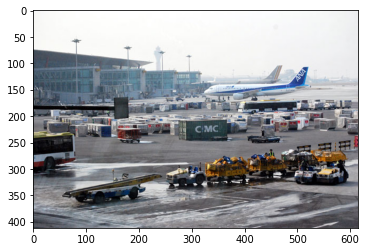

In [34]:
import matplotlib.pyplot as plt
plt.imshow(airport)

## Model predictions

Now let's use predict the objects in the airport test image we found in the scivision catalog, using the loaded object detection models. The output can be visualised with scivision's `display_objects` function.

In [35]:
fb_model_objects = facebook_model.predict(airport)

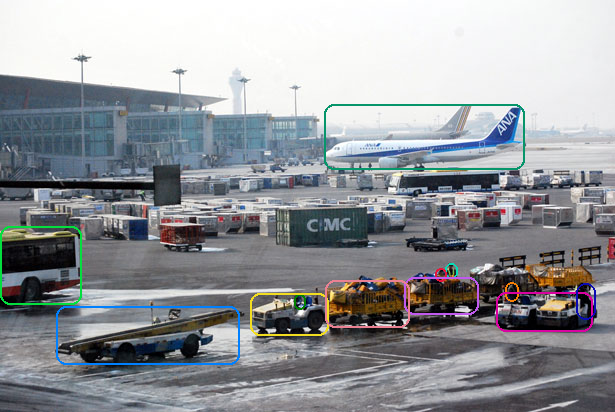

/Users/echalstrey/projects/scivision/scivision/vis/display.py:74: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  object_predictions = pd.DataFrame(predictions).drop('box', 1)


,score,label,bbox
0,0.968878,truck,0
1,0.970690,person,1
2,0.969587,truck,2
3,0.982232,person,3
4,0.978991,person,4
5,0.912243,person,5
6,0.988615,truck,6
7,0.988031,bus,7
8,0.953983,person,8
9,0.902741,truck,9


In [36]:
display_objects(airport, fb_model_objects)

In [37]:
yolo_model_objects = yolo_model.predict(airport)

Now let's try the other model we loaded. We can also set the optional `label_nums` flag so the bounding boxes are numbered as well as colored.

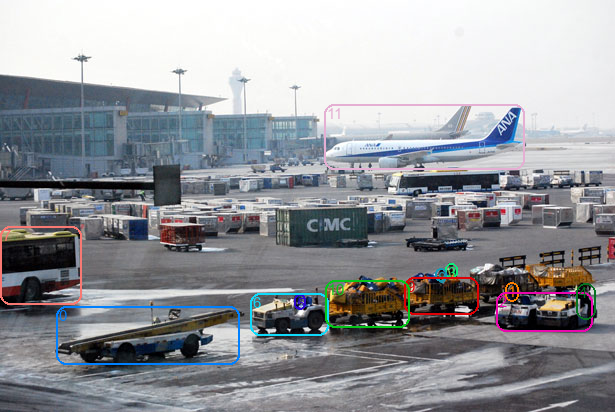

/Users/echalstrey/projects/scivision/scivision/vis/display.py:74: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  object_predictions = pd.DataFrame(predictions).drop('box', 1)


,score,label,bbox
0,0.968878,truck,0
1,0.970690,person,1
2,0.969587,truck,2
3,0.982232,person,3
4,0.978991,person,4
5,0.912243,person,5
6,0.988615,truck,6
7,0.988031,bus,7
8,0.953983,person,8
9,0.902741,truck,9


In [38]:
display_objects(airport, yolo_model_objects, label_nums=True)

What does the output from the model predict look like? This format is accepted by `display_objects`:

In [39]:
fb_model_objects

[{'score': 0.968877911567688,
  'label': 'truck',
  'box': {'xmin': 56, 'ymin': 306, 'xmax': 239, 'ymax': 364}},
 {'score': 0.9706903696060181,
  'label': 'person',
  'box': {'xmin': 505, 'ymin': 282, 'xmax': 518, 'ymax': 301}},
 {'score': 0.9695870280265808,
  'label': 'truck',
  'box': {'xmin': 496, 'ymin': 292, 'xmax': 592, 'ymax': 331}},
 {'score': 0.982231855392456,
  'label': 'person',
  'box': {'xmin': 445, 'ymin': 263, 'xmax': 457, 'ymax': 278}},
 {'score': 0.9789905548095703,
  'label': 'person',
  'box': {'xmin': 576, 'ymin': 283, 'xmax': 595, 'ymax': 319}},
 {'score': 0.9122430682182312,
  'label': 'person',
  'box': {'xmin': 294, 'ymin': 294, 'xmax': 305, 'ymax': 309}},
 {'score': 0.9886151552200317,
  'label': 'truck',
  'box': {'xmin': 250, 'ymin': 293, 'xmax': 328, 'ymax': 335}},
 {'score': 0.988030731678009,
  'label': 'bus',
  'box': {'xmin': 0, 'ymin': 226, 'xmax': 81, 'ymax': 304}},
 {'score': 0.9539830088615417,
  'label': 'person',
  'box': {'xmin': 435, 'ymin': 26